In [2]:
import pandas as pd
import numpy as np

## AFC thématiques

On commence par charger les données sur les thématiques des chaînes.

In [3]:
path = "Data/Classement thématique des sujets de journeaux télévisés/ina-barometre-jt-tv-donnees-quotidiennes-2000-2020-nbre-sujets-durees-202410.csv" 
df = pd.read_csv(path, encoding="latin-1", sep=";", header=None)
df.describe()


,2,4,5
count,0.0,268424.000000,268424.000000
mean,NaN,2.184745,194.009098
std,NaN,1.917227,203.621299
min,NaN,1.000000,1.000000
25%,NaN,1.000000,89.000000
50%,NaN,2.000000,134.000000
75%,NaN,3.000000,242.000000
max,NaN,102.000000,16125.000000


On construit la table de contingence.

In [4]:
themes = df[3].unique()
chaines = df[1].unique()
df_eff = pd.DataFrame(columns=themes, index=chaines)

for th in themes:
    for ch in chaines:
        temps = df[(df[1]==ch) & (df[3]==th)][5].sum()
        df_eff.loc[ch, th] = temps

df_eff = df_eff.astype(float)

On applique l'AFC à celle-ci pour observer les corrélations entre chaîne et thématique abordée.

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple

class AFC():
    
    def __init__(self):
        return None
        
    def fit(self, df_contingence:pd.DataFrame):
        """Calcule l'AFC de la matrice de contingeance donnée en entrée et affiche le résultat.

        Args:
            df_contingence (pd.DataFrame): une matrice de contingeance entre deux variables qualitatives

        Returns:
            Tuple[np.ndarray, np.ndarray, np.ndarray]: le triplet (U, s, Vt) issu de la SVD de la matrice d'inertie.
        """
        
        # Calcul des fréquences relatives
        self.contingence = df_contingence
        n_total = self.contingence.values.sum()
        P = self.contingence / n_total  # Matrice de fréquences
        row_sums = P.sum(axis=1)  # Totaux des lignes
        col_sums = P.sum(axis=0)  # Totaux des colonnes

        # Matrice centrée et réduite (matrice de résidus)
        E = np.outer(row_sums, col_sums).astype(float)  # Matrice attendue sous hypothèse d'indépendance
        Z = (P - E) / np.sqrt(E)  # Matrice des résidus du Chi2

        # Décomposition en valeurs singulières (SVD)
        self.U, self.s, self.Vt = np.linalg.svd(Z, full_matrices=False)
        
        # Calcul des coordonnées factorielles & de l'inertie expliquée par les axes
        self.row_coordinates = self.U * self.s  # Coordonnées des lignes
        self.col_coordinates = self.Vt.T * self.s  # Coordonnées des colonnes
        self.explained_inertia = 100*(self.s ** 2) / np.sum(self.s ** 2)
        
        # Qualité de représetation
        cos2_row = (self.row_coordinates**2) / np.sum(self.row_coordinates**2, axis=1)[:, np.newaxis]
        cos2_col = (self.col_coordinates**2) / np.sum(self.col_coordinates**2, axis=1)[:, np.newaxis]
        self.cos2_row = pd.DataFrame(cos2_row, 
                                     columns=[f'Axe {i+1}' for i in range(cos2_row.shape[1])],
                                     index = self.contingence.index)
        self.cos2_col = pd.DataFrame(cos2_col, 
                                     columns=[f'Axe {i+1}' for i in range(cos2_row.shape[1])],
                                     index = self.contingence.columns)
        
        # Contribution des lignes
        contrib_row = (self.row_coordinates**2 / self.s**2) * row_sums.values[:, np.newaxis]
        contrib_row = contrib_row / contrib_row.sum(axis=0)
        self.contrib_row = pd.DataFrame(contrib_row, 
                                     columns=[f'Axe {i+1}' for i in range(contrib_row.shape[1])],
                                     index = self.contingence.index)
        
        # Contribution des colonnes
        contrib_col = (self.col_coordinates**2 / self.s**2) * col_sums.values[:, np.newaxis]
        contrib_col = contrib_col / contrib_col.sum(axis=0)
        self.contrib_col = pd.DataFrame(contrib_col, 
                                     columns=[f'Axe {i+1}' for i in range(contrib_col.shape[1])],
                                     index = self.contingence.columns)
        
    def plot(self, title: str = ''):
        """ Trace le graphe de l'AFC."""
        
        # Étape 5 : Visualisation des résultats
        plt.figure(figsize=(8, 8))
        plt.axhline(0, linestyle='--', color='grey')
        plt.axvline(0, linestyle='--', color='grey')

        # Coordonnées des lignes
        for i, (x, y) in enumerate(zip(self.row_coordinates[:, 0], self.row_coordinates[:, 1])):
            plt.scatter(x, y, label=self.contingence.index[i], color='blue')
            plt.text(x, y, self.contingence.index[i], color='blue')

        # Coordonnées des colonnes
        for i, (x, y) in enumerate(zip(self.col_coordinates[:, 0], self.col_coordinates[:, 1])):
            plt.scatter(x, y, label=self.contingence.columns[i], color='red')
            plt.text(x, y, self.contingence.columns[i], color='red')

        plt.title(title)
        plt.xlabel(f'Axe 1 ({np.round(self.explained_inertia[0],2)} %)')
        plt.ylabel(f'Axe 2 ({np.round(self.explained_inertia[1],2)} %)')
        plt.grid()
        plt.show()
        
    def qualite(self):
        """Affiche les qualités de représentations de chaque modalités sur les axes"""
        
        print("Qualité de représentation des modalités lignes")
        print(self.cos2_row)
        print("-----------------------------------------------------------------")
        print("Qualité de représentation des modalités colonnes")
        print (self.cos2_col)
        
    def contribution(self):
        """Affiche la contribution de chaque modalité aux axes"""
        
        print("Contibutions des modalités lignes")
        print(self.contrib_row)
        print("-----------------------------------------------------------------")
        print("Contributions des modalités colonnes")
        print (self.contrib_col)


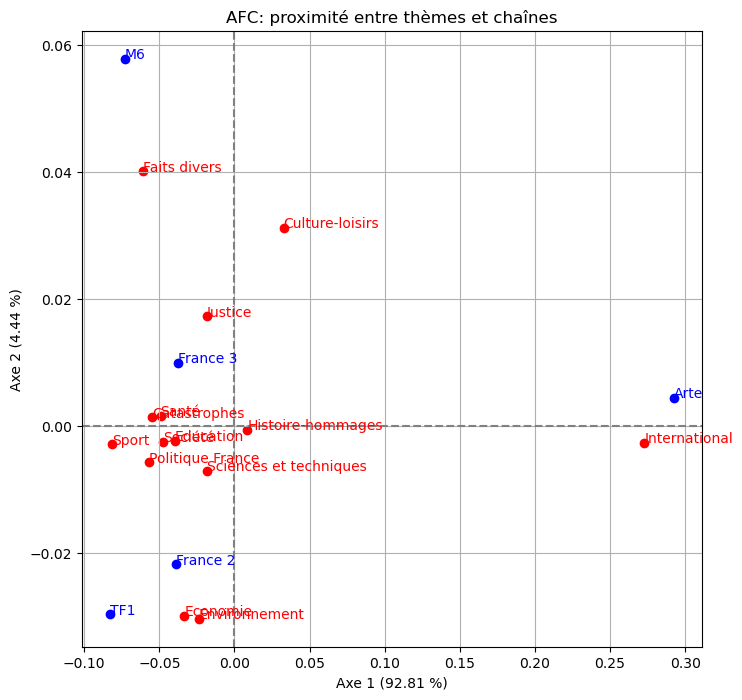

In [38]:
afc = AFC()
afc.fit(df_eff)
afc.plot("AFC: proximité entre thèmes et chaînes")

In [39]:
afc.qualite()

Qualité de représentation des modalités lignes
             Axe 1     Axe 2     Axe 3     Axe 4         Axe 5
France 3  0.483461  0.033539  0.440907  0.042093  4.825953e-31
Arte      0.999421  0.000229  0.000340  0.000010  1.215525e-32
M6        0.598341  0.374028  0.026282  0.001349  1.172123e-31
France 2  0.629815  0.196668  0.069353  0.104163  9.070586e-31
TF1       0.797200  0.102474  0.091461  0.008865  2.477100e-31
-----------------------------------------------------------------
Qualité de représentation des modalités colonnes
                           Axe 1     Axe 2         Axe 3     Axe 4  \
Catastrophes            0.979307  0.000612  7.899034e-04  0.019291   
Culture-loisirs         0.458348  0.416455  7.708320e-02  0.048113   
Environnement           0.339384  0.551363  8.371018e-02  0.025543   
International           0.999783  0.000095  1.281835e-07  0.000122   
Société                 0.987614  0.002733  3.575965e-03  0.006077   
Sport                   0.968204  0.0012

In [36]:
afc.contribution()

Contibutions des modalités lignes
             Axe 1     Axe 2     Axe 3     Axe 4     Axe 5
France 3  0.017702  0.021397  0.443797  0.195838  0.149682
Arte      0.776930  0.003102  0.007267  0.001001  0.080044
M6        0.048864  0.532214  0.059004  0.013997  0.081085
France 2  0.028977  0.157661  0.087720  0.608966  0.353518
TF1       0.127528  0.285626  0.402212  0.180198  0.335670
-----------------------------------------------------------------
Contributions des modalités colonnes
                           Axe 1     Axe 2         Axe 3     Axe 4     Axe 5
Catastrophes            0.011520  0.000337  7.789761e-04  0.094308  0.010994
Culture-loisirs         0.007019  0.298197  9.896061e-02  0.306210  0.182017
Environnement           0.001827  0.138782  3.777840e-02  0.057146  0.082561
International           0.870061  0.003877  9.351415e-06  0.044022  0.197421
Société                 0.030135  0.003899  9.147145e-03  0.077059  0.071691
Sport                   0.026429  0.001594  6.9